## Text Mining - TP Stocks - Grupo 4

### Librerias

In [108]:
import pandas as pd
import nltk
nltk.download('stopwords')
import spacy
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Archivo entrenamiento

In [65]:
data = pd.read_excel('C:/Users/ferna/Downloads/ypf_v6.xlsx', sheet_name= 'UNIFICADO')

### Stopwords

In [3]:
stopwords_en = set(stopwords.words('english'))

In [4]:
word_count = {}

for sentence in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    words = sentence.split()
    
    for word in words:
        word = word.strip(".,!?()").lower()
        
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

In [5]:
word_count_filtro = {word: count for word, count in word_count.items() if word not in stopwords_en}

In [6]:
word_counts_orden = dict(sorted(word_count_filtro.items(), key=lambda x: x[1], reverse=True))

In [7]:
df = pd.DataFrame(list(word_counts_orden.items()), columns=['Palabra', 'Frecuencia'])

file_path = 'stopwords_pos_orden.xlsx'

df.to_excel(file_path, index=False)

In [8]:
# Listado de stopwords propio
stopwords_personales = ['Refinitiv','Zacks','Rystad','Andrew','Rocco','Nilanjan','Benerjee','CERAWEEK','Tirthankar','Chakraborty','Anindya','Barman','Scott','Squires','Jonathan','Gilbert','Yvonne','Yue','Li'
                        'Laura','Millan','Jorgelina','Do','Rosario']

stopwords_personales = [x.lower() for x in stopwords_personales]

stopwords_custom = stopwords_en.union(stopwords_personales)

### Power Words

In [9]:
column1_values = data['Power Word 01'].tolist()
column2_values = data['Power Word 02'].tolist()
column3_values = data['Power Word 03'].tolist()
column4_values = data['Power Word 04'].tolist()
column5_values = data['Power Word 05'].tolist()
column6_values = data['Power Word 06'].tolist()
column7_values = data['Power Word 07'].tolist()
column8_values = data['Power Word 08'].tolist()

In [10]:
combined_values = set(
    column1_values + 
    column2_values + 
    column3_values + 
    column4_values + 
    column5_values + 
    column6_values + 
    column7_values + 
    column8_values
    )

In [11]:
unique_values_list = list(combined_values)
unique_values_list = [value for value in unique_values_list if pd.notna(value)]
powerWords = [str(value).lower() for value in unique_values_list]

### Lematización

In [12]:
def func_lemma(X_train, dicc_stopwords):
    
    nlp = spacy.load("en_core_web_sm")
    
    X_train_lemma = []

    for noticia in X_train:
        l_doc = nlp(noticia)
        v_lema = " ".join([token.lemma_.lower() for token in l_doc if token.text.lower() not in dicc_stopwords and not token.is_punct])
        X_train_lemma.append(v_lema)

    return X_train_lemma

### Split Train / Test

In [13]:
data_train = data[data['Train/Test'].isin(['Train'])]
data_test = data[data['Train/Test'].isin(['Test'])]

In [14]:
X_train = data_train['Text'].tolist()
y_train = data_train['Category'].tolist()

In [15]:
X_test = data_test['Text'].tolist()
y_test = data_test['Category'].tolist()

## Lemma (Similitud del Coseno y Jaccard)

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

list1 = X_train
list2 = func_lemma(X_train, stopwords_custom)
vectorizer = CountVectorizer()

data_lemma = []

for str1, str2 in zip(list1, list2):
    tokens1 = str1.split()
    tokens2 = str2.split()

    matrix1 = vectorizer.fit_transform([" ".join(tokens1)])
    matrix2 = vectorizer.transform([" ".join(tokens2)])
    
    cosine_sim = cosine_similarity(matrix1, matrix2)[0][0]

    data_lemma.append([str1, str2, cosine_sim])

df_lemma = pd.DataFrame(data_lemma, columns=["Original", "Lemma", "Sim_Coseno"])

In [19]:
df_lemma.head()

,Original,Lemma,Sim_Coseno
0,\nYPF Sociedad Anonima (YPF) Gains But Lags M...,\n ypf sociedad anonima ypf gain lags market ...,0.823387
1,YPF Sociedad Anonima (YPF) Gains But Lags Mark...,ypf sociedad anonima ypf gain lags market know,0.801784
2,15 Cheap Growth Stocks to Buy —,15 cheap growth stock buy,0.816497
3,\nYPF Sociedad Anonima (YPF) Outpaces Stock M...,\n ypf sociedad anonima ypf outpaces stock ma...,0.858898
4,\nAre Investors Undervaluing YPF Sociedad Ano...,\n investor undervalue ypf sociedad anonima y...,0.797724


In [20]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords_custom]
    return filtered_tokens

original_text = " ".join(list1)
lemmatized_text = " ".join(list2)

original_tokens = original_text.split()
lemmatized_tokens = lemmatized_text.split()

filtered_original_tokens = remove_stopwords(original_tokens)
filtered_lemmatized_tokens = remove_stopwords(lemmatized_tokens)

original_unique_words = set(filtered_original_tokens)
lemmatized_unique_words = set(filtered_lemmatized_tokens)

total_unique_words_original = len(original_unique_words)
total_unique_words_lemmatized = len(lemmatized_unique_words)

print(f"Diccionario original: {total_unique_words_original}")
print(f"Diccionario lematizado: {total_unique_words_lemmatized}")

Diccionario original: 1710
Diccionario lematizado: 1252


## Regresión Logistica

### Pipeline

In [21]:
clf_lr = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

clf_lr_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

### Entrenamiento

In [22]:
clf_lr = clf_lr.fit(X_train, y_train)

clf_lr_sw = clf_lr_sw.fit(X_train, y_train)

clf_lr_lema = clf_lr.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [23]:
y_pred_lr = clf_lr.predict(X_test)

y_pred_lr_sw = clf_lr_sw.predict(X_test)

y_pred_lr_lema = clf_lr_lema.predict(X_test)

### Predicción ( Probabilidad )

In [24]:
y_pred_lr_proba = clf_lr.predict_proba(X_test)

y_pred_lr_sw_proba = clf_lr_sw.predict_proba(X_test)

y_pred_lr_lema_proba = clf_lr_lema.predict_proba(X_test)

### Evaluación

In [25]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lr_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_lr_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_sw))

Accuracy: 69.05%

F1 Score: 68.99

Confusion Matrix:
 [[32 12]
 [14 26]]


## Naive Bayes Multinomial

### Pipeline

In [26]:
clf_nb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

clf_nb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

### Entrenamiento

In [27]:
clf_nb = clf_nb.fit(X_train, y_train)

clf_nb_sw = clf_nb_sw.fit(X_train, y_train)

clf_nb_lema = clf_nb.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [28]:
y_pred_nb = clf_nb.predict(X_test)

y_pred_nb_sw = clf_nb_sw.predict(X_test)

y_pred_nb_lema = clf_nb_lema.predict(X_test)

### Predicción ( Probabilidad )

In [29]:
y_pred_nb_proba = clf_nb.predict_proba(X_test)

y_pred_nb_sw_proba = clf_nb_sw.predict_proba(X_test)

y_pred_nb_lema_proba = clf_nb_lema.predict_proba(X_test)

In [30]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


In [31]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_sw))

Accuracy: 66.67%

F1 Score: 64.66

Confusion Matrix:
 [[39  5]
 [23 17]]


In [32]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_lema))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


## Support Vector Classifier

### Pipeline

In [33]:
clf_svc = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_proba = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

clf_svc_sw_proba = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

### Entrenamiento

In [34]:
clf_svc = clf_svc.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw.fit(X_train, y_train)

clf_svc_lema = clf_svc.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [35]:
y_pred_svc = clf_svc.predict(X_test)

y_pred_svc_sw = clf_svc_sw.predict(X_test)

y_pred_svc_lema = clf_svc_lema.predict(X_test)

### Predicción ( Probabilidad )

In [36]:
clf_svc = clf_svc_proba.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw_proba.fit(X_train, y_train)

clf_svc_lema = clf_svc_proba.fit(func_lemma(X_train,stopwords_custom), y_train)

In [37]:
y_pred_svc_proba = clf_svc.predict_proba(X_test)

y_pred_svc_sw_proba = clf_svc_sw.predict_proba(X_test)

y_pred_svc_lema_proba = clf_svc_lema.predict_proba(X_test)

In [38]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


In [39]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_sw))

Accuracy: 69.05%

F1 Score: 68.91

Confusion Matrix:
 [[33 11]
 [15 25]]


In [40]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_lema))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


## Random Forest

In [41]:
clf_rf = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

clf_rf_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

In [42]:
clf_rf = clf_rf.fit(X_train, y_train)

clf_rf_sw = clf_rf_sw.fit(X_train, y_train)

In [43]:
y_pred_rf = clf_rf.predict(X_test)

y_pred_rf_sw = clf_rf_sw.predict(X_test)

y_pred_rf_proba = clf_rf.predict_proba(X_test)

y_pred_rf_sw_proba = clf_rf_sw.predict_proba(X_test)

In [44]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 67.86%

F1 Score: 67.83

Confusion Matrix:
 [[28 16]
 [11 29]]


## Mapeo etiquetas

In [45]:
y_train_gb = data_train["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()
y_test_gb = data_test["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()

In [46]:
def map_value(value):
    if value == 0:
        return "Compra"
    else:
        return "Neutro"

## XGBoost

In [47]:
clf_xgb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

clf_xgb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

In [48]:
clf_xgb = clf_xgb.fit(X_train, y_train_gb)

clf_xgb_sw = clf_xgb_sw.fit(X_train, y_train_gb)

In [49]:
y_pred_xgb = clf_xgb.predict(X_test)

y_pred_xgb_sw = clf_xgb_sw.predict(X_test)

y_pred_xgb_proba = clf_xgb.predict_proba(X_test)

y_pred_xgb_sw_proba = clf_xgb_sw.predict_proba(X_test)

In [50]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_xgb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_xgb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_xgb_sw))

Accuracy: 67.86%

F1 Score: 67.83

Confusion Matrix:
 [[31 13]
 [14 26]]


In [51]:
y_pred_xgb = [map_value(value) for value in y_pred_xgb]
y_pred_xgb_sw = [map_value(value) for value in y_pred_xgb_sw]

## LightGBM

In [52]:
clf_lgbm = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

clf_lgbm_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

In [53]:
clf_lgbm = clf_lgbm.fit(X_train, y_train_gb)

clf_lgbm_sw = clf_lgbm_sw.fit(X_train, y_train_gb)

[LightGBM] [Info] Number of positive: 104, number of negative: 119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466368 -> initscore=-0.134733
[LightGBM] [Info] Start training from score -0.134733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [54]:
y_pred_lgbm = clf_lgbm.predict(X_test)

y_pred_lgbm_sw = clf_lgbm_sw.predict(X_test)

y_pred_lgbm_proba = clf_lgbm.predict_proba(X_test)

y_pred_lgbm_sw_proba = clf_lgbm_sw.predict_proba(X_test)

In [55]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_lgbm_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_lgbm_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_lgbm_sw))

Accuracy: 66.67%

F1 Score: 66.61

Confusion Matrix:
 [[31 13]
 [15 25]]


In [56]:
y_pred_lgbm = [map_value(value) for value in y_pred_lgbm]
y_pred_lgbm_sw = [map_value(value) for value in y_pred_lgbm_sw]

## Word2Vec

In [61]:
import gensim

GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/ferna/Downloads/GoogleNews-vectors-negative300.bin.gz', binary = True,)

In [66]:
corpus = data['Text'].values

vectorizer = CountVectorizer(stop_words = stopwords_custom)

X = vectorizer.fit_transform(corpus)

CountVectorizedData = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
CountVectorizedData['Category'] = data['Category']
CountVectorizedData['Split'] = data['Train/Test']

WordsVocab = CountVectorizedData.columns[:-2]

In [62]:
def FunctionText2Vec(inpTextData):
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    W2Vec_Data=pd.DataFrame()
    
    for i in range(CountVecData.shape[0]):

        Sentence = np.zeros(300)

        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            if word in GoogleModel.key_to_index.keys():    
                Sentence = Sentence+GoogleModel[word]
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [67]:
W2Vec_Data = FunctionText2Vec(data['Text'])

C:\Users\ferna\AppData\Local\Temp\ipykernel_18344\4248583333.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_18344\4248583333.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_18344\4248583333.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_18344\4248583333.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.a

In [68]:
W2Vec_Data.reset_index(inplace = True, drop = True)
W2Vec_Data['Category'] = CountVectorizedData['Category']
W2Vec_Data['Split'] = CountVectorizedData['Split']

#Guardo en una nueva variable
DataForML = W2Vec_Data
DataForML.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Category,Split
0,-2.612555,2.180817,-1.901596,1.644066,-1.403992,-1.067413,-0.307095,-4.590302,2.898636,2.488464,...,-2.055801,0.468796,-0.720398,2.189514,1.395073,-1.224696,3.168865,0.697662,Compra,Test
1,-0.508713,0.286743,-0.364624,0.789124,-0.309082,-0.173096,-0.136915,-1.236511,0.088135,0.748535,...,-0.525635,0.188965,-0.358215,-0.001160,0.426758,-0.012695,0.228577,0.652832,Neutro,Test
2,-1.198853,0.419434,0.174988,1.057617,0.130371,-0.629639,-0.363281,-0.318420,1.475220,0.394287,...,-0.613571,-0.082520,-0.168777,0.079407,-0.608887,0.413452,-0.147217,0.217896,Neutro,Test
3,-0.383850,0.420654,-0.848045,1.532227,-0.171814,-0.470337,0.114746,-1.177734,0.987747,0.189453,...,0.282227,0.486572,-0.264526,-0.026611,0.344727,0.009125,0.493851,-0.514343,Neutro,Test
4,-0.804199,0.151947,-0.002197,1.969971,0.229736,-0.707275,-0.181442,-1.224335,1.526321,-0.257568,...,0.598938,0.256836,0.175415,0.811646,-0.064941,-0.156067,0.452118,-0.225708,Neutro,Test


In [75]:
TargetVariable = DataForML.columns[-2]
Predictors = DataForML.columns[:-2]

X = DataForML[Predictors].values
y = DataForML[TargetVariable].values

train_mask = DataForML['Split'] == 'Train'
test_mask = DataForML['Split'] == 'Test'

X_train = DataForML[train_mask][Predictors].values
y_train = DataForML[train_mask][TargetVariable].values
X_test = DataForML[test_mask][Predictors].values
y_test = DataForML[test_mask][TargetVariable].values

#Normalizo para los modelos de ML
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [132]:
w2v_results = {}

### Naive Bayes

In [143]:
clf = MultinomialNB()

#Entranamiento y predicción
NB = clf.fit(X_train, y_train)
prediction = NB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Naive Bayes'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.56      0.41      0.47        44
      Neutro       0.50      0.65      0.57        40

    accuracy                           0.52        84
   macro avg       0.53      0.53      0.52        84
weighted avg       0.53      0.52      0.52        84

-----------------------------------------------------
[[18 14]
 [26 26]]
-----------------------------------------------------
Accuracy en TEST data: 0.52


### KNN (K-Nearest Neighbor)

In [144]:
clf = KNeighborsClassifier(n_neighbors=15)

#Entranamiento y predicción
KNN = clf.fit(X_train,y_train)
prediction = KNN.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['KNN'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.62      0.70      0.66        44
      Neutro       0.62      0.53      0.57        40

    accuracy                           0.62        84
   macro avg       0.62      0.61      0.61        84
weighted avg       0.62      0.62      0.62        84

-----------------------------------------------------
[[31 19]
 [13 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.62


### Regresión Logística

In [145]:
#'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
clf = LogisticRegression(C=10,penalty='l2', solver='newton-cg')

LOG = clf.fit(X_train,y_train)
prediction = LOG.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Logistic Regression'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.74      0.66      0.70        44
      Neutro       0.67      0.75      0.71        40

    accuracy                           0.70        84
   macro avg       0.71      0.70      0.70        84
weighted avg       0.71      0.70      0.70        84

-----------------------------------------------------
[[29 10]
 [15 30]]
-----------------------------------------------------
Accuracy en TEST data: 0.7


### Árbol de Decisión

In [146]:
clf = DecisionTreeClassifier(max_depth = 20, criterion = 'gini')

DTree = clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Decision Tree'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.51      0.45      0.48        44
      Neutro       0.47      0.53      0.49        40

    accuracy                           0.49        84
   macro avg       0.49      0.49      0.49        84
weighted avg       0.49      0.49      0.49        84

-----------------------------------------------------
[[20 19]
 [24 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.49


### Random Forest

In [147]:
clf = RandomForestClassifier(max_depth = 20)

RF = clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Random Forest'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.51      0.45      0.48        44
      Neutro       0.47      0.53      0.49        40

    accuracy                           0.49        84
   macro avg       0.49      0.49      0.49        84
weighted avg       0.49      0.49      0.49        84

-----------------------------------------------------
[[20 19]
 [24 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.49


### XGBoost

In [148]:
#Necesito codificar las etiquetas
cat_encoded = LabelEncoder()
y_train_encoded = cat_encoded.fit_transform(y_train)
y_test_encoded = cat_encoded.transform(y_test)

clf = XGBClassifier()

XGB = clf.fit(X_train, y_train_encoded)
prediction = XGB.predict(X_test)

print(classification_report(y_test_encoded, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test_encoded))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test_encoded, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['XGBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.67      0.60      0.63        40

    accuracy                           0.67        84
   macro avg       0.67      0.66      0.66        84
weighted avg       0.67      0.67      0.67        84

-----------------------------------------------------
[[32 16]
 [12 24]]
-----------------------------------------------------
Accuracy en TEST data: 0.67


### LightGBM

In [306]:
# Set the verbosity level to suppress messages
lgbm_params = {
    'verbosity': -1  # Set verbosity to -1 to suppress all messages
}

clf = LGBMClassifier(**lgbm_params)

LGBM = clf.fit(X_train,y_train)
prediction = LGBM.predict(X_test)
y_pred_w2v_lgbm = prediction
y_pred_w2v_lgbm_proba = LGBM.predict_proba(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['LightGBM'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.75      0.75      0.75        44
      Neutro       0.72      0.72      0.73        40

    accuracy                           0.74        84
   macro avg       0.74      0.74      0.74        84
weighted avg       0.74      0.74      0.74        84

-----------------------------------------------------
[[33 11]
 [11 29]]
-----------------------------------------------------
Accuracy en TEST data: 0.74


### AdaBoost

In [150]:
DTC = DecisionTreeClassifier(max_depth = 2)
clf = AdaBoostClassifier(n_estimators = 20, base_estimator = DTC , learning_rate = 0.01)


AB = clf.fit(X_train,y_train)
prediction = AB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['AdaBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.60      0.66      0.63        44
      Neutro       0.58      0.53      0.55        40

    accuracy                           0.60        84
   macro avg       0.59      0.59      0.59        84
weighted avg       0.59      0.60      0.59        84

-----------------------------------------------------
[[29 19]
 [15 21]]
-----------------------------------------------------
Accuracy en TEST data: 0.59


In [151]:
w2v_results

{'Naive Bayes': 0.52,
 'KNN': 0.62,
 'Logistic Regression': 0.7,
 'Decision Tree': 0.49,
 'Random Forest': 0.49,
 'XGBoost': 0.67,
 'LightGBM': 0.74,
 'AdaBoost': 0.59}

## BERT

In [256]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [260]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
    def __len__(self):
            return len(self.texts)
    
    def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [261]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [262]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [263]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [289]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "Neutro" if preds.item() == 1 else "Compra"

In [301]:
def predict_sentiment_with_probabilities(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
    
    label_probabilities = {
        "Compra": probabilities[0][0].item(),
        "Neutro": probabilities[0][1].item()
    }
    
    return label_probabilities

In [265]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [274]:
train_texts = data_train['Text'].tolist()
train_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_train['Category'].tolist()]

val_texts = data_test['Text'].tolist()
val_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_test['Category'].tolist()]

In [275]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [276]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [277]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [278]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4


Validation Accuracy: 0.5476
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        44
           1       1.00      0.05      0.10        40

    accuracy                           0.55        84
   macro avg       0.77      0.53      0.40        84
weighted avg       0.76      0.55      0.41        84

Epoch 2/4
Validation Accuracy: 0.7024
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        44
           1       0.78      0.53      0.63        40

    accuracy                           0.70        84
   macro avg       0.72      0.69      0.69        84
weighted avg       0.72      0.70      0.69        84

Epoch 3/4
Validation Accuracy: 0.7024
              precision    recall  f1-score   support

           0       0.66      0.91      0.76        44
           1       0.83      0.47      0.60        40

    accuracy                           0.70        84
   macro avg       0.74 

In [279]:
torch.save(model.state_dict(), "bert_classifier.pth")

In [304]:
test_text = "YPF call volume above normal and directionally bullish"
label_probabilities  = predict_sentiment_with_probabilities(test_text, model, tokenizer, device)
print("Prediccion:")
for label, probability in label_probabilities.items():
    print(f"{label}: {probability:.4f}")

Prediccion:
Compra: 0.6218
Neutro: 0.3782


In [319]:
X_test = data_test['Text'].tolist()

y_pred_bert = []
predicted_probabilities = []

for text in X_test:
    label_probabilities = predict_sentiment_with_probabilities(text, model, tokenizer, device)
    
    predicted_label = max(label_probabilities, key=label_probabilities.get)
    
    y_pred_bert.append(predicted_label)
    
    predicted_probabilities.append([label_probabilities["Compra"], label_probabilities["Neutro"]])

y_pred_bert_proba = np.array(predicted_probabilities)

### Output

In [320]:
models_pred = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'RegLog': y_pred_lr,
        'RegLog_SW': y_pred_lr_sw,
        'MultinomialNB': y_pred_nb,
        'MultinomialNB_SW': y_pred_nb_sw,
        'SVC': y_pred_svc,
        'SVC_SW': y_pred_svc_sw,
        'RF':y_pred_rf,
        'RF_SW': y_pred_rf_sw,
        'XGB': y_pred_xgb,
        'XGB_SW': y_pred_xgb_sw,
        'LightGBM': y_pred_lgbm,
        'LightGBM_SW': y_pred_lgbm_sw,
        'Word2Vec_LGBM': y_pred_w2v_lgbm,
        'BERT': y_pred_bert
    }
)

In [321]:
models_pred.head()

,X_test,y_test,RegLog,RegLog_SW,MultinomialNB,MultinomialNB_SW,SVC,SVC_SW,RF,RF_SW,XGB,XGB_SW,LightGBM,LightGBM_SW,Word2Vec_LGBM,BERT
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra,Compra,Compra,Compra,Compra,Neutro,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Neutro,Compra,Neutro,Compra,Compra,Compra,Neutro
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Compra,Neutro,Neutro,Compra
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Neutro,Compra,Neutro,Compra,Neutro,Compra,Compra,Neutro,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra


In [322]:
models_pred.to_excel('ypf_predicciones_modelos.xlsx', index=False)

## Probabilidades

In [324]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba
]

## Ensamble

In [325]:
v_probas = len(probas)
v_length = len(probas[0])

y_pred_ensemble_proba = [[0] * 2 for _ in range(v_length)]

for proba in range(0,v_probas):
    for row in range(0,v_length):
        for category in range(0,2):
            y_pred_ensemble_proba[row][category] += probas[proba][row][category]

for row in range(0,v_length):
    for category in range(0,2):
        y_pred_ensemble_proba[row][category] = y_pred_ensemble_proba[row][category]/v_probas

In [326]:
v_data = {}
for i in range(2):
    column_name = chr(65 + i)
    v_data[column_name] = [inner_list[i] for inner_list in y_pred_ensemble_proba]

df = pd.DataFrame(v_data)

In [327]:
prob_ensemble = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'Compra': df['A'].values.tolist(),
        'Neutro': df['B'].values.tolist()
    }
)

In [329]:
prob_ensemble

,X_test,y_test,Compra,Neutro
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.657619,0.342381
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.611954,0.388046
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.343861,0.656139
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.516847,0.483153
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.551070,0.448930
...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.406149,0.593851
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.799809,0.200191
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.634468,0.365532
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.238331,0.761669


In [330]:
prob_ensemble['Ensemble Label'] = prob_ensemble[['Compra', 'Neutro']].idxmax(axis=1)

In [331]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.657619,0.342381,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.611954,0.388046,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.343861,0.656139,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.516847,0.483153,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.551070,0.448930,Compra
...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.406149,0.593851,Neutro
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.799809,0.200191,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.634468,0.365532,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.238331,0.761669,Neutro


## AUC/ROC

In [332]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba,
    np.array(y_pred_ensemble_proba)
]

In [333]:
class_labels = ['Compra', 'Neutro']

label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_test)

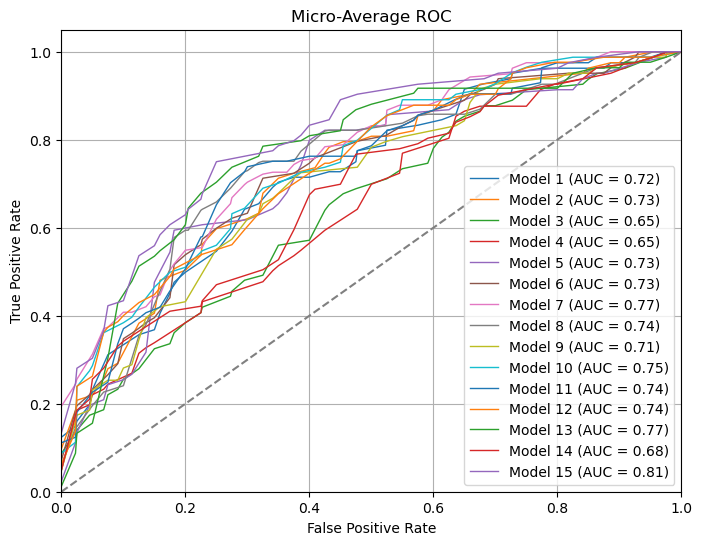

In [334]:
plt.figure(figsize=(8, 6))

for i, y_pred_probabilities in enumerate(probas):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(class_labels) 
    for j in range(n_classes):
        y_true_class = (y_true_encoded == j).astype(int)
        fpr[j], tpr[j], _ = roc_curve(y_true_class, y_pred_probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])

    mean_tpr /= n_classes
    roc_auc_micro = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, lw=1, label=f'Model {i+1} (AUC = {roc_auc_micro:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Bag Of Words

In [167]:
word_counts = {}

for noticia in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    tokens = noticia.split()
    
    for palabra in tokens:
        palabra = palabra.strip(".,!?()").lower()
        if palabra not in stopwords_custom:
            if palabra in word_counts:
                word_counts[palabra] += 1
            else:
                word_counts[palabra] = 1
                
word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

## Power Words

In [335]:
prob_ensemble['CompraIndex'] = 0

for index, noticia in enumerate(prob_ensemble['X_test']):
    tokens = noticia.split()
    
    for palabra in tokens:
        palabra = palabra.strip(".,!?()").lower()
        if palabra in powerWords:
            prob_ensemble.loc[index, 'CompraIndex'] += 0.1

In [337]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.657619,0.342381,Compra,0.4
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.611954,0.388046,Compra,0.0
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.343861,0.656139,Neutro,0.1
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.516847,0.483153,Compra,0.0
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.551070,0.448930,Compra,0.0
...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.406149,0.593851,Neutro,0.6
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.799809,0.200191,Compra,0.2
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.634468,0.365532,Compra,0.5
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.238331,0.761669,Neutro,0.0


In [338]:
# Si CompraIndex > 0.2 entonces cambiar el label a Compra
def CheckPowerWord(row):
    if row['CompraIndex'] >= 0.6 and row['Ensemble Label'] == 'Neutro':
        return 'Compra'
    else:
        return row['Ensemble Label']

prob_ensemble["PowerLabel"] = prob_ensemble.apply(CheckPowerWord, axis=1)

In [339]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex,PowerLabel
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.657619,0.342381,Compra,0.4,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.611954,0.388046,Compra,0.0,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.343861,0.656139,Neutro,0.1,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.516847,0.483153,Compra,0.0,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.551070,0.448930,Compra,0.0,Compra
...,...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.406149,0.593851,Neutro,0.6,Compra
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.799809,0.200191,Compra,0.2,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.634468,0.365532,Compra,0.5,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.238331,0.761669,Neutro,0.0,Neutro


In [341]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["Ensemble Label"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["Ensemble Label"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["Ensemble Label"].to_list()))

Accuracy: 71.43%

F1 Score: 71.30

Confusion Matrix:
 [[34 10]
 [14 26]]


In [342]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["PowerLabel"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["PowerLabel"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["PowerLabel"].to_list()))

Accuracy: 75.00%

F1 Score: 74.72

Confusion Matrix:
 [[37  7]
 [14 26]]


In [201]:
prob_ensemble.to_excel('ypf_predicciones_ensemble_power_v1.xlsx', index=False)